# Numerai Auxiliary Feature EDA

---
## Load libraries & training data

In [ ]:
# change working directory
import os
os.chdir('/Users/davidhuang/Documents/GitHub/numerai-models')

In [1]:
# libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from numerapi import NumerAPI
from utils.utils import ERA_COL, TARGET_COL, DATA_TYPE_COL
import gc


In [2]:
# see current round
napi = NumerAPI()
current_round = napi.get_current_round()
print(f"Current round #: {current_round}")

Current round #: 316


In [3]:
# read training data
with open("data/features.json", "r") as f:
    feature_metadata = json.load(f)
features = list(feature_metadata["feature_stats"].keys())
read_columns = features + [TARGET_COL, ERA_COL, DATA_TYPE_COL]

training = pd.read_parquet('data/train.parquet', columns=read_columns)

---
# Compute era-wise feature-target correlations

In [4]:
# calculate feature-target corr for each sera
corr_list = []

for f in features:
    corr = training.groupby("era")[[f, TARGET_COL]].corr(method="spearman").unstack().iloc[:,1]
    corr_list.append(corr)

In [9]:
# concat to a single df
corr_df = pd.concat(corr_list, axis=1)
corr_df.columns = features

In [6]:
# create corr by features
fcorr_df = corr_df.copy().T

---
# High-level EDA on correlation by eras

In [18]:
# set rolling factor
ROLLING_FACTOR = 26
SELECTION_FACTOR = 200

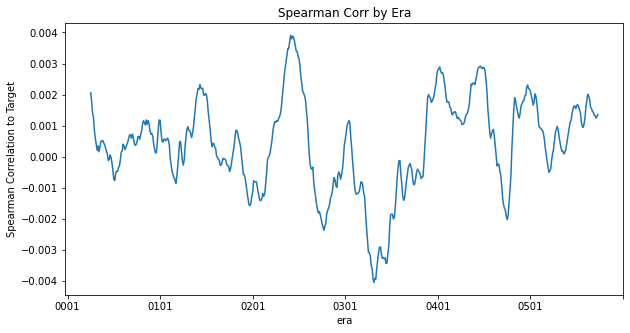

In [19]:
# plot mean corr by eras
corr_df.mean(axis=1).rolling(ROLLING_FACTOR).mean().plot(figsize=(10, 5))
plt.xlabel('era')
plt.ylabel('Spearman Correlation to Target')
plt.title('Spearman Corr by Era')
plt.show()

In [20]:
# get top features by mean spearman corr
top_features = corr_df.mean().sort_values(ascending=False)[:SELECTION_FACTOR]
bottom_features = corr_df.mean().sort_values(ascending=True)[:SELECTION_FACTOR]

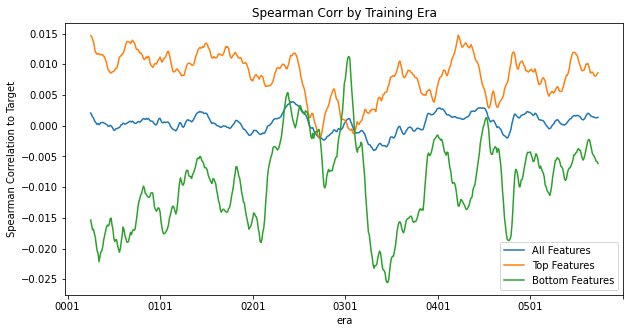

In [21]:
# plot by eras
corr_df.mean(axis=1).rolling(ROLLING_FACTOR).mean().plot(figsize=(10, 5))
corr_df[top_features.index].mean(axis=1).rolling(ROLLING_FACTOR).mean().plot(figsize=(10, 5))
corr_df[bottom_features.index].mean(axis=1).rolling(ROLLING_FACTOR).mean().plot(figsize=(10, 5))
plt.xlabel('era')
plt.ylabel('Spearman Correlation to Target')
plt.title('Spearman Corr by Training Era')
plt.legend(["All Features", "Top Features", "Bottom Features"])
plt.show()

In [22]:
# free up memory
gc.collect()

7024

---
# Correlations in validation eras

In [13]:
# load validation dataset
validation = pd.read_parquet('data/validation.parquet', columns=read_columns)

In [14]:
# calculate feature-target corr for each sera
vcorr_list = []

for f in features:
    vcorr = validation.groupby("era")[[f, TARGET_COL]].corr(method="spearman").unstack().iloc[:,1]
    vcorr_list.append(vcorr)

In [15]:
# concat to a single df
vcorr_df = pd.concat(vcorr_list, axis=1)
vcorr_df.columns = features

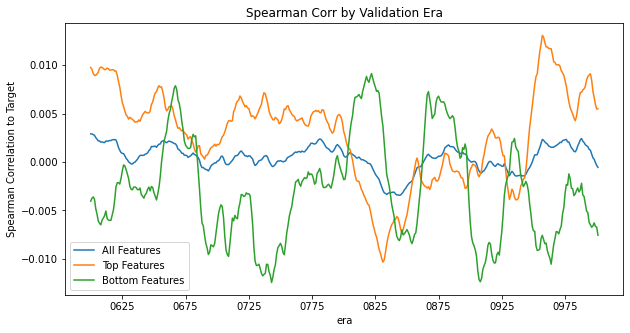

In [23]:
# plot by eras
vcorr_df.mean(axis=1).rolling(ROLLING_FACTOR).mean().plot(figsize=(10, 5))
vcorr_df[top_features.index].mean(axis=1).rolling(ROLLING_FACTOR).mean().plot(figsize=(10, 5))
vcorr_df[bottom_features.index].mean(axis=1).rolling(ROLLING_FACTOR).mean().plot(figsize=(10, 5))
plt.xlabel('era')
plt.ylabel('Spearman Correlation to Target')
plt.title('Spearman Corr by Validation Era')
plt.legend(["All Features", "Top Features", "Bottom Features"])
plt.show()

In [43]:
# save names of top and bottom features
top_bottom_json = {
    "top_features": top_features.index.tolist(),
    "bottom_features": bottom_features.index.tolist()
}

with open("data/top_bottom_features.json", "w") as outfile:
    json.dump(top_bottom_json, outfile, indent = 4)

In [44]:
# free up memory
gc.collect()

33

---
# Find optimal K for K-Means clustering

In [45]:
# import sklearn kmeans
from sklearn.cluster import KMeans

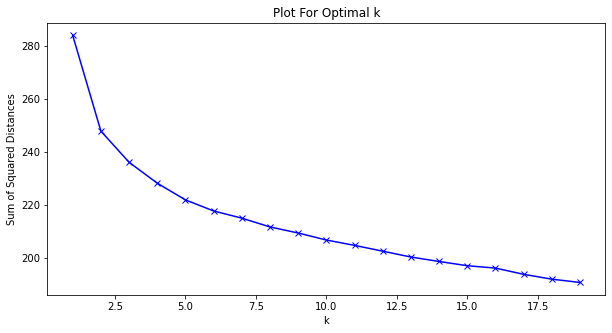

In [46]:
# instantiate clustering
K = 20
ssdist_0 = []
for k in range(1, K):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(corr_df)
    ssdist_0.append(kmeans.inertia_)

# plot inertia
plt.figure(figsize=(10, 5))
plt.plot(range(1, K), ssdist_0, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Plot For Optimal k')
plt.show()

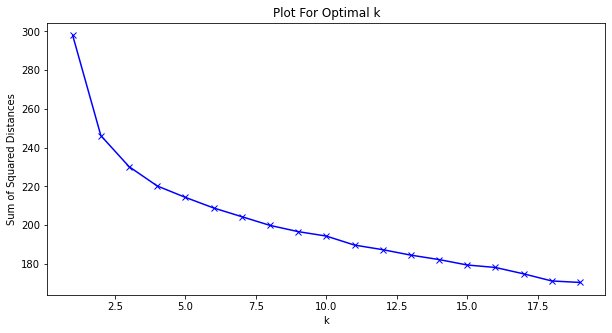

In [47]:
# instantiate clustering
K = 20
ssdist_1 = []
for k in range(1, K):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(fcorr_df)
    ssdist_1.append(kmeans.inertia_)

# plot inertia
plt.figure(figsize=(10, 5))
plt.plot(range(1, K), ssdist_1, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Plot For Optimal k')
plt.show()

In [48]:
# free up memory
gc.collect()

6045

---
# Find optimal Epsilon for DBSCAN clustering

In [49]:
# import sklearn dbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

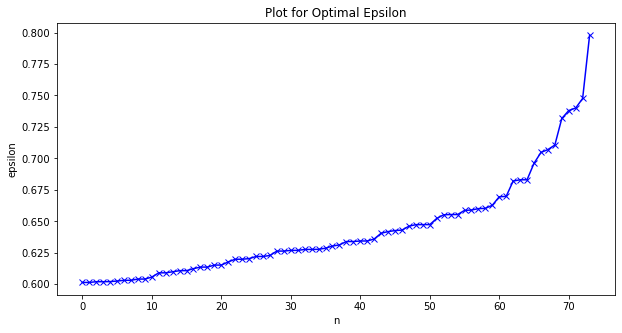

In [50]:
# compute distances
neighbors_0 = NearestNeighbors(n_neighbors=20)
neighbors_fit_0 = neighbors_0.fit(corr_df)
distances_0, indices_0 = neighbors_fit_0.kneighbors(corr_df)
distances_0 = np.sort(distances_0, axis=0)
distances_0 = distances_0[:,1]

plt.figure(figsize=(10, 5))
plt.plot(distances_0[500:], 'bx-')
plt.xlabel('n')
plt.ylabel('epsilon')
plt.title('Plot for Optimal Epsilon')
plt.show()

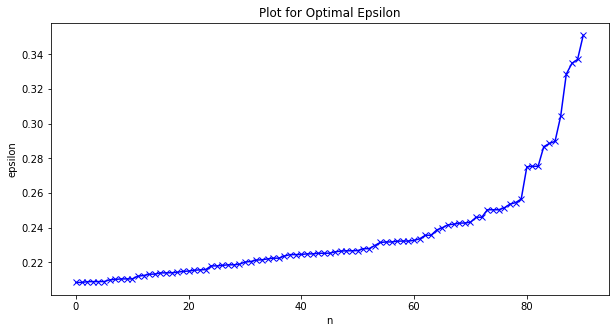

In [51]:
# compute distances
neighbors_1 = NearestNeighbors(n_neighbors=20)
neighbors_fit_1 = neighbors_1.fit(fcorr_df)
distances_1, indices_1 = neighbors_fit_1.kneighbors(fcorr_df)
distances_1 = np.sort(distances_1, axis=0)
distances_1 = distances_1[:,1]

plt.figure(figsize=(10, 5))
plt.plot(distances_1[1100:], 'bx-')
plt.xlabel('n')
plt.ylabel('epsilon')
plt.title('Plot for Optimal Epsilon')
plt.show()

In [52]:
# free up memory
gc.collect()

6263

---
# Compute clusters via DBSCAN

In [53]:
# perform clustering
model_0 = DBSCAN(eps=0.675, min_samples=7)
model_0.fit(corr_df)
cluster_0 = model_0.labels_

pd.DataFrame(cluster_0).groupby(0).size()

0
-1    283
 0    281
 1      5
 2      5
dtype: int64

In [54]:
# perform clustering
model_1 = DBSCAN(eps=0.25, min_samples=10)
model_1.fit(fcorr_df)
cluster_1 = model_1.labels_

pd.DataFrame(cluster_1).groupby(0).size()

0
-1    1065
 0      34
 1      10
 2      10
 3      10
 4      10
 5      10
 6      12
 7      10
 8      10
 9      10
dtype: int64